# 从准确率>0.6的类别中，准确率相同的类别各选一类
最终选出index_list =  ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

save_path = './data_stage2/class_acc_vit_b_16.json'
# save_path = './data_stage3/class_acc_vgg16.json'
acc = json.load(open(save_path))

# 提取键和值
values = list(acc.values())

# 创建图形并设置大小
plt.figure(figsize=(10, 4))

# 绘制柱状图
plt.bar(range(len(values)), values, color='lightblue', width=1)
plt.title('Accuracy for each category')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)  # 设置y轴范围以更好地显示差异
plt.xticks([])  # 隐藏x轴
# plt.grid(axis='y', linestyle='--', linewidth=0.5)  # 仅显示y轴的网格线

# 显示图形
plt.show()

In [ ]:
min(list(acc.values()))

In [ ]:
import random

# 过滤出值大于 0.6 的唯一值
unique_acc_values = {v for v in acc.values() if v >= 0}

# 根据唯一值分组
acc_groups = {value: [] for value in unique_acc_values}
for category, accuracy in acc.items():
    if accuracy >= 0:
        acc_groups[accuracy].append(category)

# 从每个分组中随机抽取一个类别
selected_categories = {random.choice(categories): accuracy for accuracy, categories in acc_groups.items()}

print(selected_categories)
print(len(selected_categories))


In [ ]:
acc

In [ ]:
# 输出selected_categories中每个类别的label号
imagenet_class_index_path='data/imagenet_class_index.json'
imagenet_class_index = json.load(open(imagenet_class_index_path))
lndexs = []
index2acc = {}
for id, (code, name) in imagenet_class_index.items():
    if code in selected_categories:
        lndexs.append(id)
        index2acc[id] = selected_categories[code]
# print(len(lndexs))
# 将index2acc按照值排序
index2acc = sorted(index2acc.items(), key=lambda x: x[1])
print(index2acc)

In [ ]:
def select_class(ranks, save_path, imagenet_class_index_path='data/imagenet_class_index.json', chinese_class_index_path = 'data/chinese_class_index.json'):
    ''' 筛选出指定排名的类别
    
    Args:
    - ranks: list, 指定的排名
    - class_index_dict: dict, 类别索引
    - chinese_class_index_dict: dict, 中文类别索引
    - acc: dict, 所有类别准确率
    '''
    with open(imagenet_class_index_path) as f:
        class_index_dict = json.load(f)

    with open(chinese_class_index_path) as f:
        chinese_class_index_dict = json.load(f)
    
    acc = json.load(open(save_path))
    
    sorted_acc = sorted(acc.items(), key=lambda x: x[1], reverse=True)
    selected_items = {k: v for i, (k, v) in enumerate(sorted_acc) if i+1 in ranks}
    result = {}
    for rank, (class_code, accuracy) in zip(ranks, selected_items.items()):
        for id, (code, name) in class_index_dict.items():
            if code == class_code:
                chinese_name = chinese_class_index_dict[str(id)]
                corect_num = int(accuracy * 50)
                result[id] = [class_code, name, chinese_name, accuracy, corect_num, rank]
                break
    return result

# 对选出来的类别进行处理

In [ ]:
import numpy as np
import json
import pandas as pd
import os

acc_path = './data_stage2/class_acc_vit_b_16.json'
imagenet_class_index_path='data/imagenet_class_index.json'
chinese_class_index_path = 'data/chinese_class_index.json'

with open(imagenet_class_index_path) as f:
    class_index_dict = json.load(f)

with open(chinese_class_index_path) as f:
    chinese_class_index_dict = json.load(f)
    
with open(acc_path) as f:
    acc = json.load(f)

rank_list = ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948']

In [ ]:
# 计算每个类别的初始loss
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from models.load_model import load_model
from data_preprocessor.load_images import CustomDataset

model_str = 'vit_b_16'
load_model(model_str)
model = load_model(model_str)
if isinstance(model, nn.DataParallel):
    model = model.module
model.eval()

loss_dict = {}
data_root = 'data_stage3/images_classified'
for index in rank_list:
    dataset_file = f'{data_root}/{index}.pth'
    dataset = CustomDataset(dataset_file)
    dataloader = DataLoader(dataset, batch_size=50, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        outputs = model(inputs)
        loss += criterion(outputs, labels).item()
    loss_dict[index] = loss / len(dataloader)
print(loss_dict)

In [ ]:
# 将id_list中的类别的id、准确率、按照准确率的排名、中文名、英文名、loss输出到DataFrame
data = []

for class_id in rank_list:
    if class_id in class_index_dict:
        imagenet_id, english_name = class_index_dict[class_id]
        accuracy = acc.get(imagenet_id, 0.0)
        loss = round(loss_dict[class_id], 4)
        data.append([class_id, accuracy, english_name, loss])

# 创建 DataFrame
df = pd.DataFrame(data, columns=['Label', 'Accuracy', 'Name', 'Loss'])

# 按照准确率排序
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 添加排名列

df['Number'] = (df['Accuracy'] * 50).astype(int)
df['Rank'] = df.index + 1

df

In [ ]:
df.to_excel('data_stage3/vit_b_16_top_20.xlsx', index=False)

# 对单步法结果文件进行处理

In [ ]:
import numpy as np
import json
import pandas as pd
import os

In [ ]:
data_rank = pd.read_excel('data_stage3/vit_b_16_top_20.xlsx')
data_rank.head()

In [ ]:
index_list = data_rank['Label'].tolist()
print(index_list)

## 结果文件处理

In [ ]:
import pandas as pd
data = pd.read_excel('./data_stage3/classified_single_attacktest_1109/classified_single_attack_1109.xlsx')
data.head()

In [ ]:
import ast
import numpy as np

def mean_of_lists(series):
    # 将每个元素转换为 NumPy 数组，然后计算均值
    arrays = np.array(series.tolist(), dtype=float)
    return np.mean(arrays, axis=0).tolist()

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr', 'channel_lowr','lrp_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    data['attack_ratio_per_channel'] = data['attack_ratio_per_channel'].apply(ast.literal_eval)
    li = ['index', 'model', 'algo', 'mask_mode', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'pixel_attacked': lambda x: int(x.mean()),
        'attack_ratio_per_channel': mean_of_lists,
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'original_loss'	: 'mean',
        'attack_loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
    }).reset_index()
    data_grouped[['R', 'G', 'B']] = pd.DataFrame(data_grouped['attack_ratio_per_channel'].tolist(), index=data_grouped.index)
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    data_grouped.drop('attack_ratio_per_channel', axis=1, inplace=True)
    
    data_rank = pd.read_excel('data_stage3/vit_b_16_top_20.xlsx')
    data_all = pd.merge(data_grouped, data_rank, left_on='index', right_on='Label', how='left')
    data_all.drop('Label', axis=1, inplace=True)

    return data_all

In [ ]:
data = merge_batch_onestep(data)

In [ ]:
data.head()

## 画图

In [ ]:
from tools.show_result_class import plot_success_rate_vs_r_single

In [ ]:
data1 = data[~data['mask_mode'].isin(['all', 'positive', 'negative'])]

In [ ]:
plot_success_rate_vs_r_single(data1, 0.01, 'fgsm', 'parameter', ['attack_loss'],mask_mode_list = ['topr', 'channel_topr', 'cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr'], id_list = [552, 751, 725])

# 多步法结果处理

In [1]:
import pandas as pd
data = pd.read_excel('./data_stage3/classified_multi_attackall_fixed_1126/classified_multi_attack_1126.xlsx')

In [2]:
data.head()

,index,model,algo,alpha,mask_mode,parameter,step,eta,l1_norm,l2_norm,success_rate,loss,pred_loss,run_time
0,460,vit_b_16,i_fgsm,0.0002,positive,NaN,0,0.01,414.7263,0.829180,0.000000,0.159134,0.159134,23.902
1,460,vit_b_16,i_fgsm,0.0002,positive,NaN,1,0.01,284.4147,0.364400,0.060606,0.207731,0.213896,23.902
2,460,vit_b_16,i_fgsm,0.0002,positive,NaN,2,0.01,379.6413,0.622129,0.060606,0.270020,0.304006,23.902
3,460,vit_b_16,i_fgsm,0.0002,positive,NaN,3,0.01,485.5219,0.987511,0.060606,0.360537,0.425832,23.902
4,460,vit_b_16,i_fgsm,0.0002,positive,NaN,4,0.01,571.6700,1.286392,0.121212,0.462302,0.574254,23.902


In [3]:
import ast
import numpy as np

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    li = ['index','model', 'algo', 'alpha', 'mask_mode', 'step', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
    }).reset_index()
    data_grouped = data_grouped.rename(columns={'loss': 'attack_loss'})
    
    
    data_rank = pd.read_excel('data_stage3/vit_b_16_top_20.xlsx')
    data_all = pd.merge(data_grouped, data_rank, left_on='index', right_on='Label', how='left')
    # 将attack_loss计算为attack_loss/Number
    data_all['attack_loss'] = data_all['attack_loss'] / data_all['Number']
    data_all.drop('Label', axis=1, inplace=True)
    
    return data_all

In [4]:
data = merge_batch_onestep(data)
data.head()

,index,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,Accuracy,Name,Loss,Number,Rank
0,110,vit_b_16,i_fgsm,0.0002,all,0,-1.0,0.01,255.2021,0.173280,0.002296,0.105621,0.0000,32.564,0.92,flatworm,0.1056,46,5
1,110,vit_b_16,i_fgsm,0.0002,all,1,-1.0,0.01,159.1027,0.064046,0.002832,0.131972,0.0000,32.564,0.92,flatworm,0.1056,46,5
2,110,vit_b_16,i_fgsm,0.0002,all,2,-1.0,0.01,205.2009,0.133176,0.003535,0.173546,0.0435,32.564,0.92,flatworm,0.1056,46,5
3,110,vit_b_16,i_fgsm,0.0002,all,3,-1.0,0.01,249.6698,0.197613,0.004358,0.224686,0.0435,32.564,0.92,flatworm,0.1056,46,5
4,110,vit_b_16,i_fgsm,0.0002,all,4,-1.0,0.01,288.1798,0.294073,0.005368,0.296412,0.1087,32.564,0.92,flatworm,0.1056,46,5


## 画出不同index，成功率和loss随step的变化


In [5]:
from tools.show_result_class import plot_success_rate_vs_step

findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not 

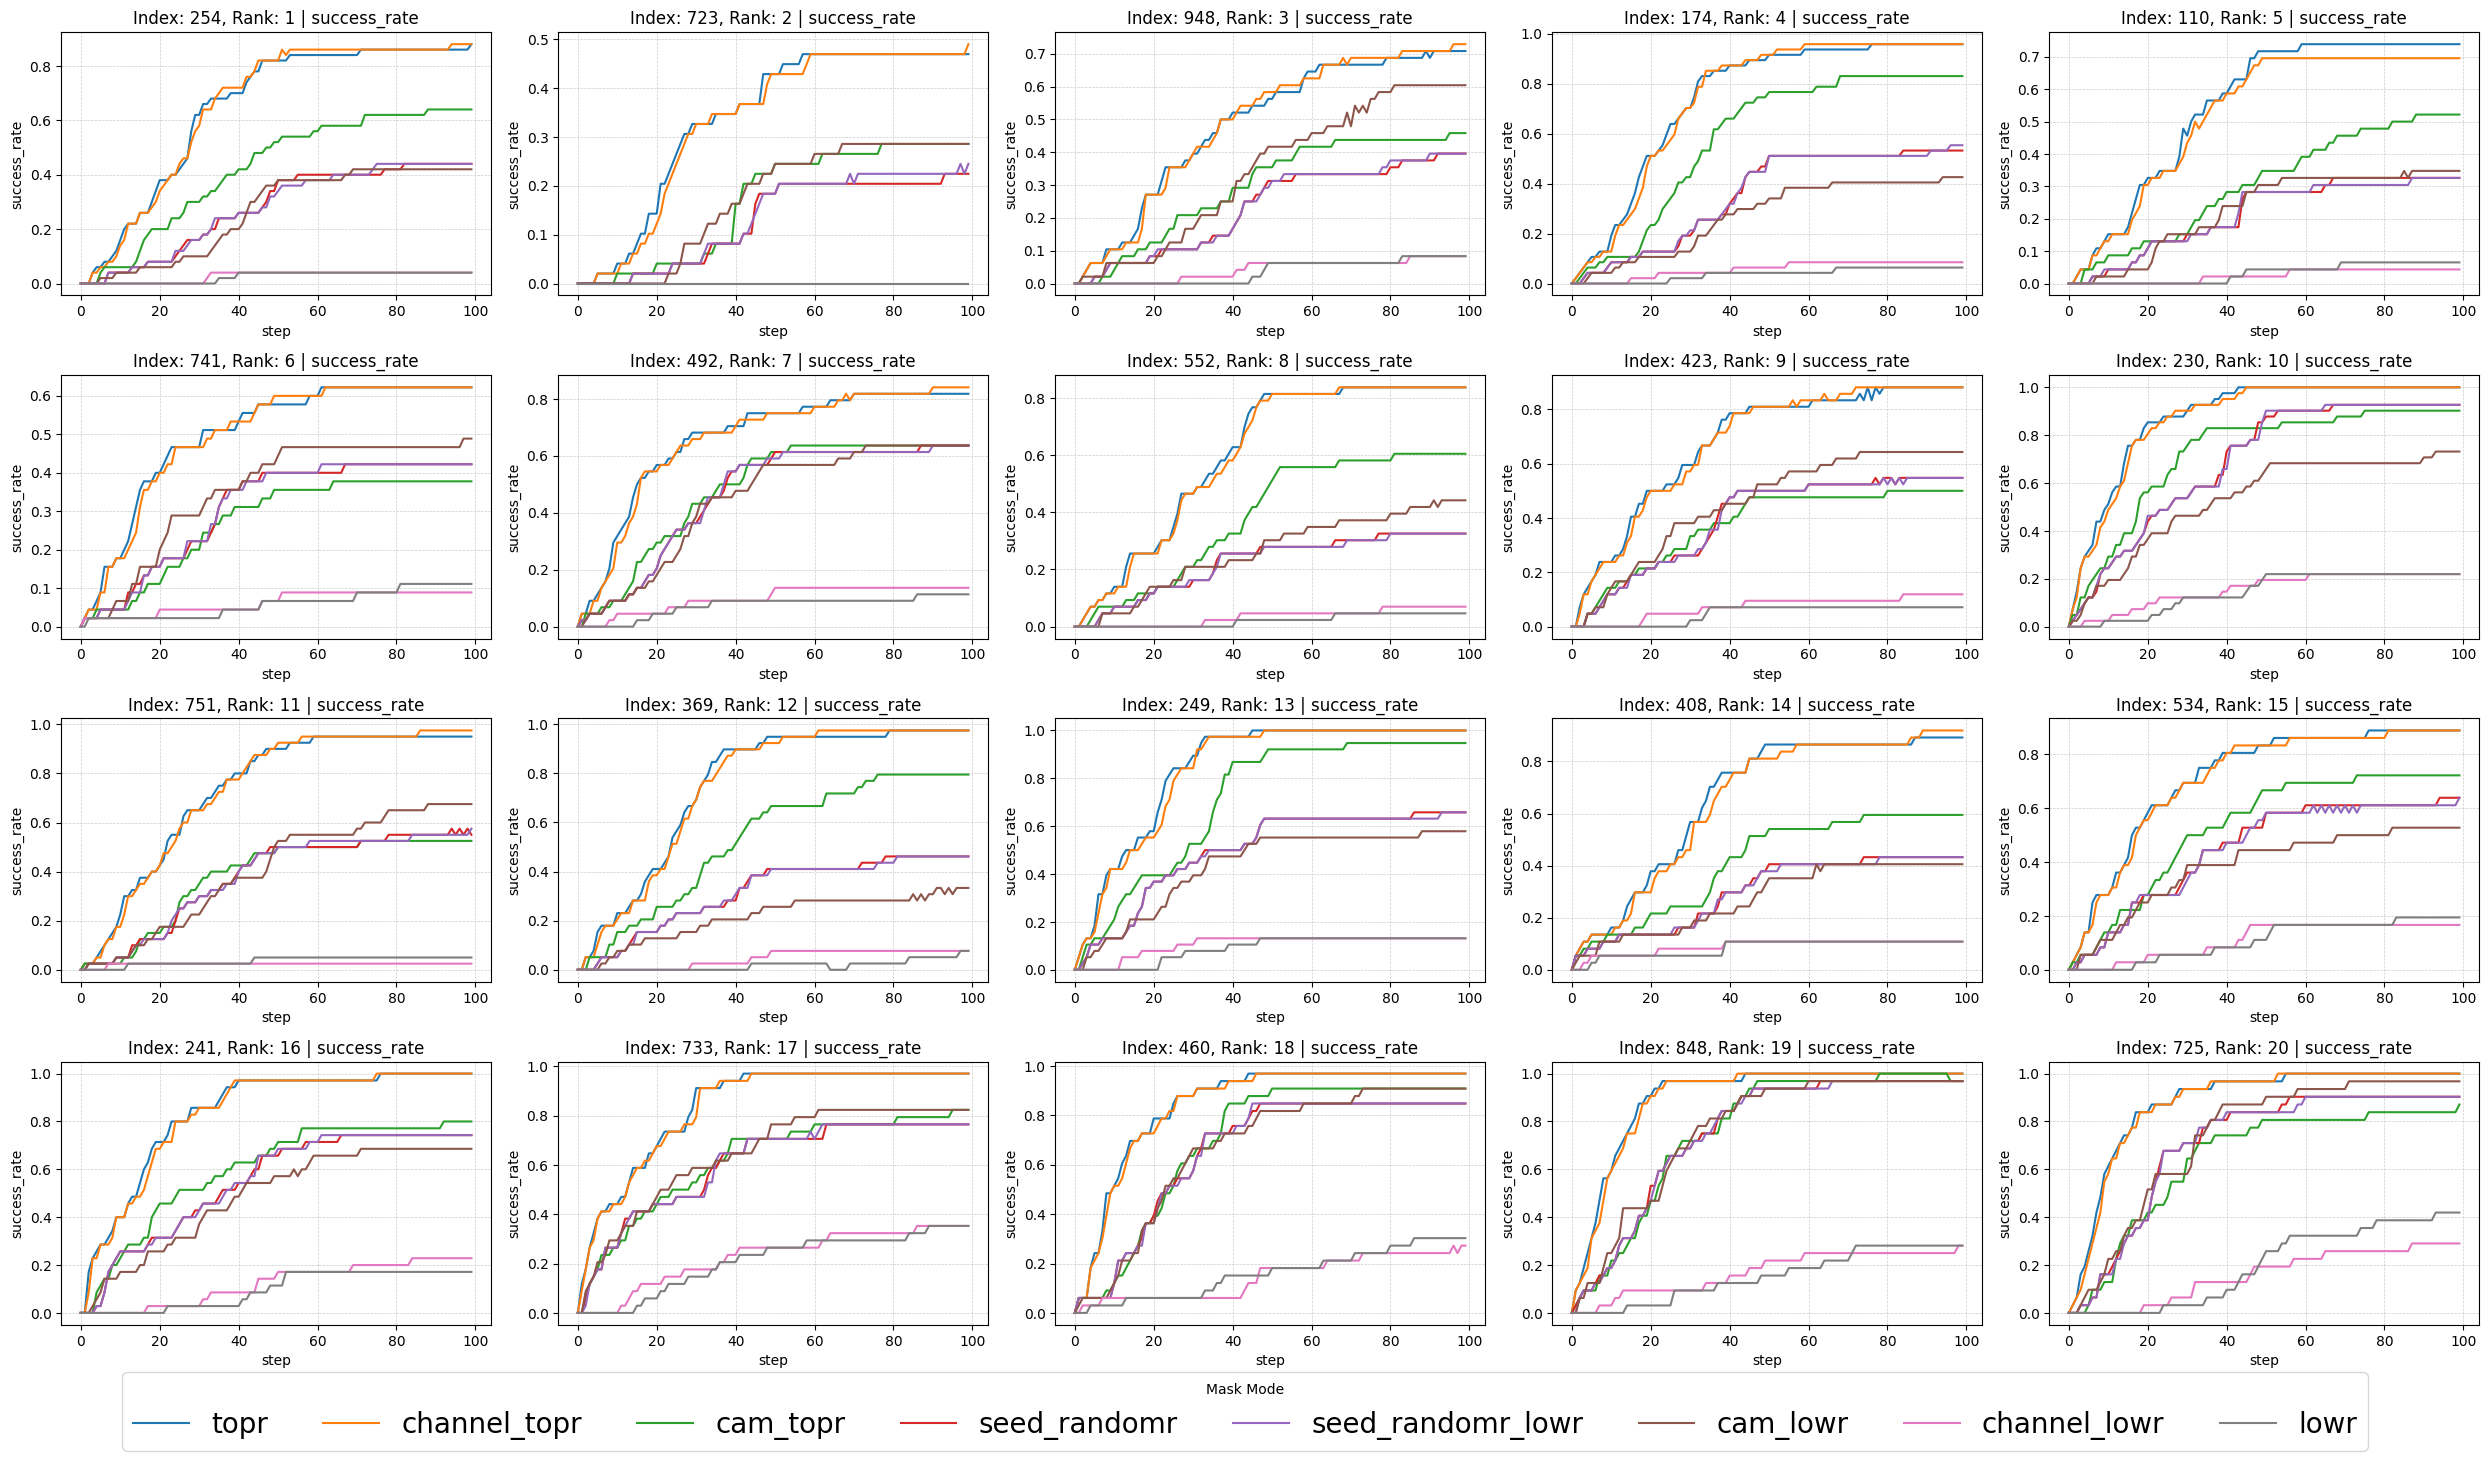

In [13]:
# mask_mode_list = ['topr', 'seed_randomr', 'lowr']
mask_mode_list = ['topr', 'channel_topr', 'cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr','channel_lowr', 'lowr', ]
plot_success_rate_vs_step(data, 0.2, 'step', ['success_rate'], mask_mode_list = mask_mode_list, output_path = 'data_stage3/classified_multi_attackall_fixed_1126',save_name = 'mask_mode_vs_class')

## 画出不同index，成功率的大小

In [ ]:
from tools.show_result_class import plot_accuracy_success_rate_and_loss, plot_accuracy_success_rate

In [8]:
# 只看step最大的
data1 = data[(data['step'] == data['step'].max())]
data1.head()

,index,model,algo,alpha,mask_mode,step,parameter,eta,l1_norm,l2_norm,attack_loss,pred_loss,success_rate,run_time,Accuracy,Name,Loss,Number,Rank
99,110,vit_b_16,i_fgsm,0.0002,all,99,-1.0,0.01,1042.3759,1.649608,0.156083,5.900882,0.9348,32.564,0.92,flatworm,0.1056,46,5
199,110,vit_b_16,i_fgsm,0.0002,cam_lowr,99,0.2,0.01,234.7701,0.846924,0.018679,1.137764,0.3478,33.074,0.92,flatworm,0.1056,46,5
299,110,vit_b_16,i_fgsm,0.0002,cam_topr,99,0.2,0.01,219.7385,1.787804,0.029565,1.762038,0.5217,36.411,0.92,flatworm,0.1056,46,5
399,110,vit_b_16,i_fgsm,0.0002,channel_lowr,99,0.2,0.01,8.8944,0.000772,0.003466,0.178887,0.0435,32.573,0.92,flatworm,0.1056,46,5
499,110,vit_b_16,i_fgsm,0.0002,channel_topr,99,0.2,0.01,470.4534,1.723101,0.054598,2.637364,0.6957,32.593,0.92,flatworm,0.1056,46,5


findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not 

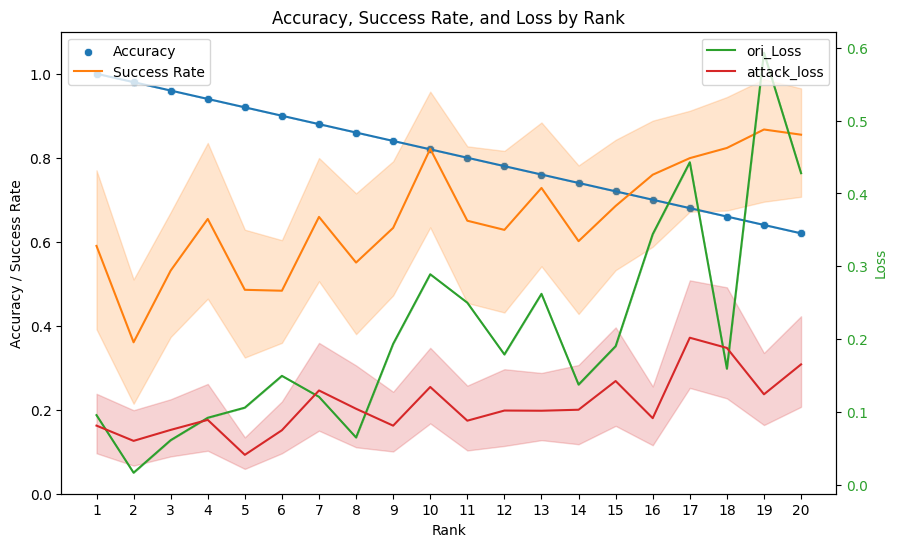

In [9]:
plot_accuracy_success_rate_and_loss(data1, output_path='./data_stage3/classified_multi_attackall_1109', save_name='acc_success_rate')

findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not 

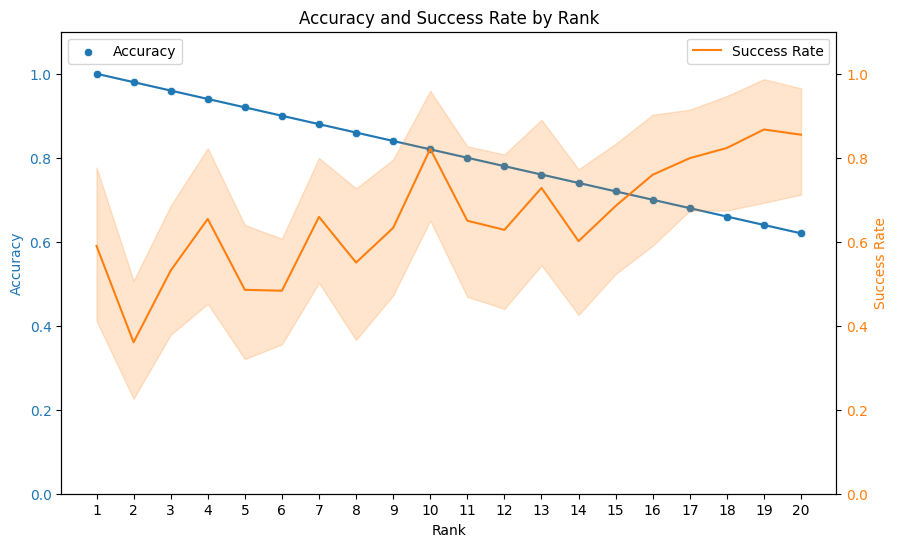

In [11]:
plot_accuracy_success_rate(data1, output_path='./data_stage3/classified_multi_attackall_fixed_1126', save_name='acc_success_rate')